# STEP 00. Import Libraries

In [2]:
import os, gzip, pickle

import pandas as pd
import numpy as np

from tqdm import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from konlpy.tag import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE 

# STEP 01. Data Load & EDA

In [3]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")
data = pd.concat([train, test], ignore_index=True)
train

,title,cleanBody,category
0,"""아시안 증오를 멈춰라""…미 전역서 규탄·추모 시위","[앵커] 애틀랜타 총격 사건으로 미국 시민들은 또한번 거리로 나왔습니다. 슬프고, ...",international
1,"한인 4명 신원 공개…희생자 아들 ""명백한 증오범죄""",[앵커] 이번 사건에서 희생된 한인 4명의 신원이 사흘 만에 공개됐습니다. 유가족과...,international
2,오늘(12일) 소상공인 버팀목자금 '짝수' 신청날…13일부터 모두 신청,12일 오전 8시부터 '버팀목자금.kr'을 통해 짝수 소상공인들로부터 버팀목자금 신...,economy
3,"""노래방에서 혼자 노래 중입니다""…새벽에도 들어온 '버팀목자금'",11일 오후 서울 황학동 중앙시장 중고가전제품 판매점에 진열된 TV에서 문재인 대통...,economy
4,'실종 2주째' 고양시 발달장애인 점퍼 한강서 발견,'실종 2주째' 고양시 발달장애인 점퍼 한강서 발견 경기 고양시 행주산성둘레길에서 ...,society
...,...,...,...
2191,"“잘나가는 일진”…‘부부의세계’ 민현서 役 심은우, 학폭 의혹","배우 심은우가 학교폭력 의혹에 휩싸였다. 8일 한 온라인 커뮤니티 게시판에는 ""저는...",entertain
2192,[헬스 프리즘] 코로나19 백신 접종으로 승기를 잡자,1년 이상 인류는 코로나19와 전쟁 중이다. 우리나라는 비교적 환자가 적게 발생하면...,society
2193,中 도발 속 코로나19와 함께 '김치 열풍' 왜?,"코로나19 확산 후 미국, 영국, 베트남 등 해외에서 '김치 열풍'이다. 최근 할리...",society
2194,"'젊은이의 양지' 배우 이지은, 자택서 숨진채 발견",90년대 인기 드라마 '젊은이의 양지'에 출연했던 배우 이지은(52)이 사망했다. ...,entertain


In [4]:
test

,title,cleanBody,category
0,"배진웅 측 ""성폭행 의혹 사실무근…보도 전 B씨 강제추행죄 고소""[공식]",후배 여배우 성폭행 의혹에 휘말린 배우 배진웅 측이 허위사실 유포에 대한 강경대응 ...,entertain
1,"배진웅 측 ""여배우 성추행 고소내용 허위""(공식)",[조이뉴스24 정명화 기자] 배우 배진웅이 동료여배우 성추행 혐의를 부인했다. 배진...,entertain
2,매일 쏟아지는 코스피 기록들…'동학개미발 가보지 않는 숫자',11일 서울 영등포구 KB국민은행 여의도지점 스마트딜링룸 전광판에 코스피지수가 전일...,economy
3,"정부, 코로나19 의료진 처우 지적에 ""인력충원 등 개선 지속 논의""",정부가 12일 신종 코로나바이러스 감염증(코로나19) 확산에 따른 의료현장 인력 부...,society
4,"집합금지 완화 토요일 발표 전망…중수본 ""엄격한 방역 조건으로 해제 검토""","정부가 11일부터 코로나19로 피해를 입은 소상공인과 고용 취약계층에 버팀목자금, ...",society
...,...,...,...
937,"日코로나 신규확진 600명…""인슐린주사기로 백신1병에 7회""",일본 수도권 일부 지역에 신종 코로나바이러스 감염증(코로나19) 긴급사태가 발령 중...,society
938,[슬라이드 뉴스] 이지은 누구? '금홍아 금홍아'로 신인상 휩쓴 '청춘스타',숨진 채 발견된 배우 이지은에 대해 관심이 쏠리고 있다. 1971년생인 이지은은 1...,entertain
939,"文 “검찰 공정성 신뢰 나아지지 않아… 기소·수사권 분리, 나아가야 할 방향”","문재인 캐리커처 문재인(얼굴) 대통령은 8일 ""기소권과 수사권 분리는 앞으로도 꾸준...",politics
940,"中, '백신여권' 도입에 ""편리한 인원왕래 요구 절실""",[서울=뉴시스] 중국 외교부가 '중국판 백신 여권'에 대해 추가적인 설명을 내놓았다...,international


<AxesSubplot:>

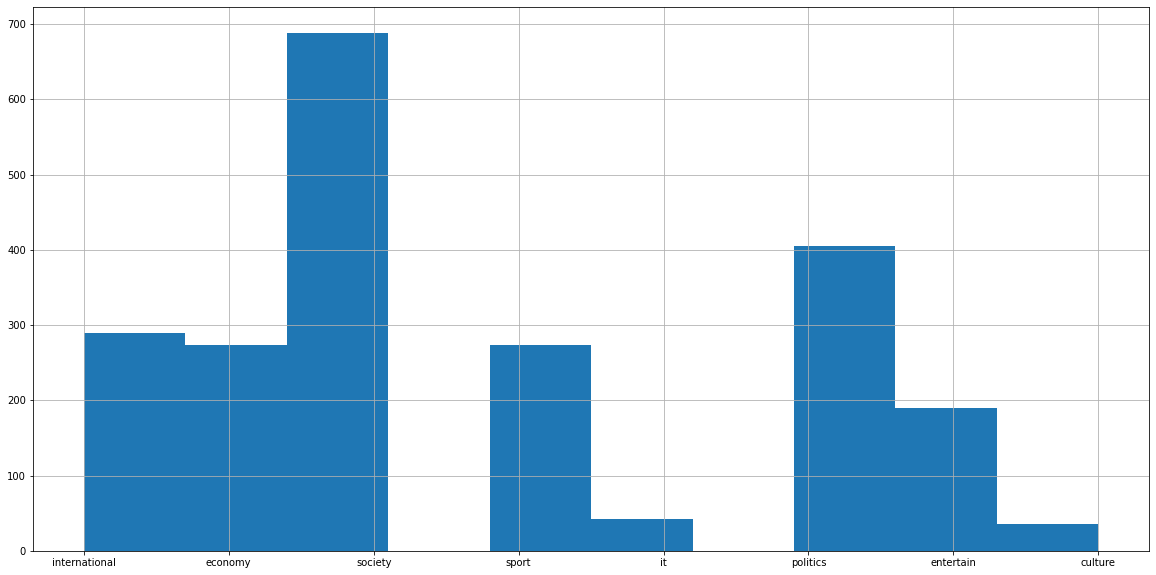

In [5]:
train.category.hist(figsize=(20,10))

<AxesSubplot:>

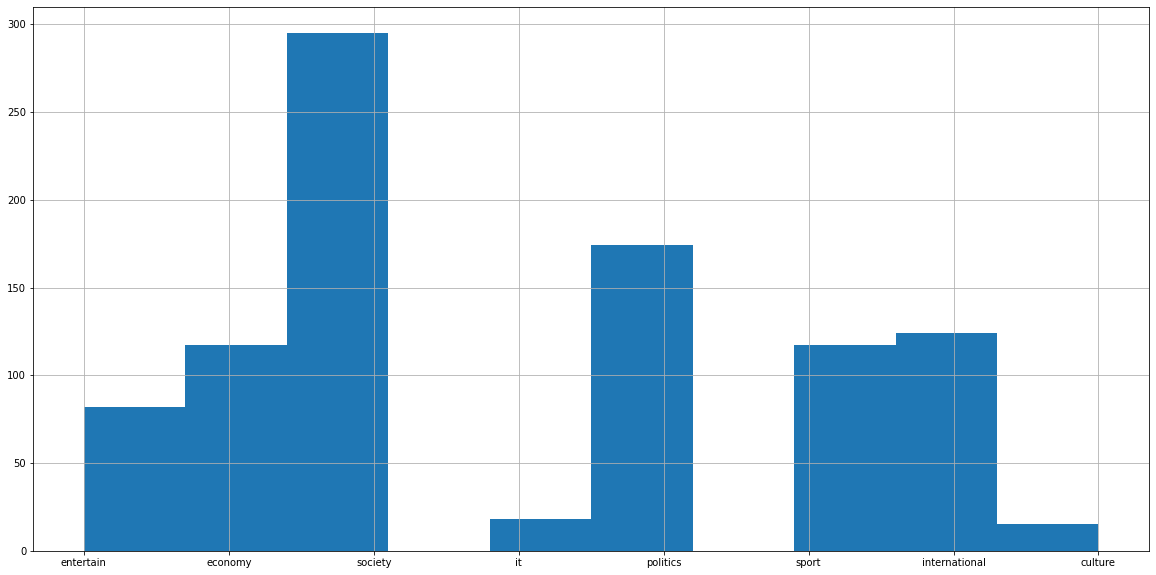

In [6]:
test.category.hist(figsize=(20,10))

<AxesSubplot:>

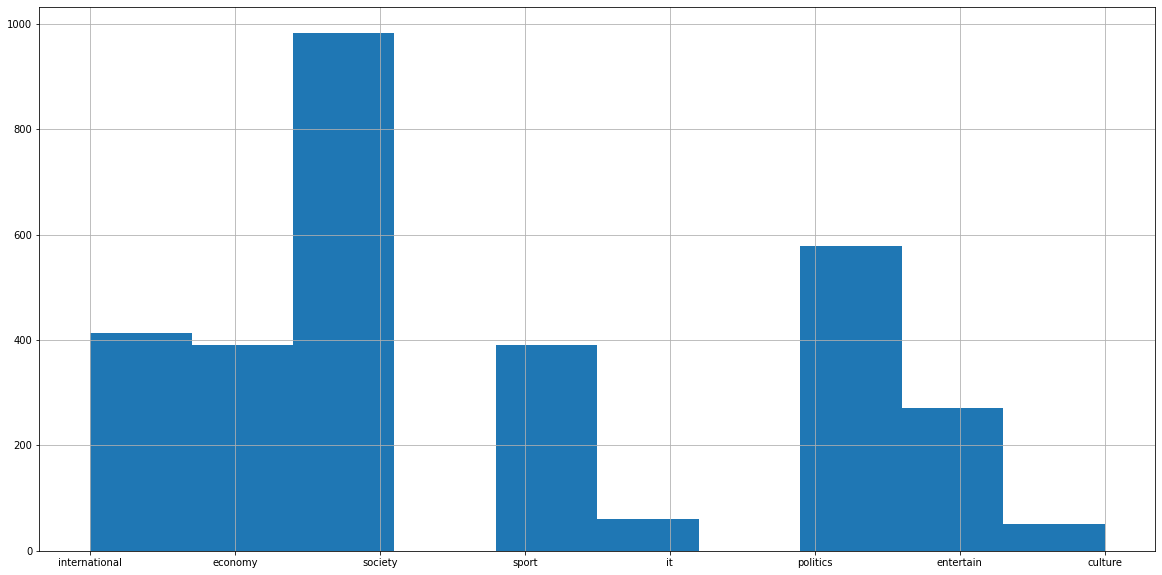

In [7]:
data.category.hist(figsize=(20,10))

<AxesSubplot:>

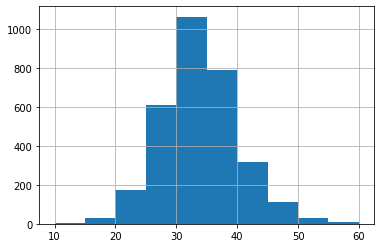

In [8]:
data.title.str.len().hist()

<AxesSubplot:>

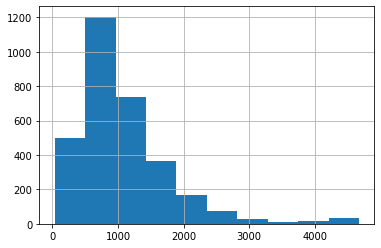

In [9]:
data.cleanBody.str.len().hist()

# STEP 02. Tokenizing

## 1. Title

In [10]:
min_df = 2

okt = Okt()

train_morph = []
for i in range(len(train)):
    train_morph.append(" ".join([x for x in okt.nouns(train['title'][i]) if len(x) > 1]))
    
test_morph = []
for i in range(len(test)):
    test_morph.append(" ".join([x for x in okt.nouns(test['title'][i]) if len(x) > 1]))

vectorizer = CountVectorizer(analyzer='word',       
                        min_df=min_df,   # 특정 횟수 이상 언급된 것만 따로                      
                        max_features=50000,             
                        )

train_vectorized = vectorizer.fit_transform(train_morph)
test_vectorized = vectorizer.transform(test_morph)

In [11]:
# exmaple
T_words = pd.DataFrame(train_vectorized.toarray(), columns=vectorizer.get_feature_names())
T_words

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,가가,가격,가구,가능,가능성,가닥,가덕도,가라,가모,가상,...,훼손,휘성,휴가,휴식,흉기,흑석,흔적,흥국생명,희망,희생
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
T_len = len(vectorizer.get_feature_names())
T_train = pd.DataFrame(train_vectorized.toarray(), columns=[i for i in range(T_len)])
T_test = pd.DataFrame(test_vectorized.toarray(), columns=[i for i in range(T_len)])

T_train.shape, T_test.shape

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


((2196, 2387), (942, 2387))

## 2. Body Text

In [13]:
min_df = 5

okt = Okt()

train_morph = []
for i in range(len(train)):
    train_morph.append(" ".join([x for x in okt.nouns(train['cleanBody'][i]) if len(x) > 1]))

test_morph = []
for i in range(len(test)):
    test_morph.append(" ".join([x for x in okt.nouns(test['cleanBody'][i]) if len(x) > 1]))

vectorizer = CountVectorizer(analyzer='word',       
                        min_df=min_df,   # 특정 횟수 이상 언급된 것만 따로                      
                        max_features=50000,             
                        )

train_vectorized = vectorizer.fit_transform(train_morph)
test_vectorized = vectorizer.transform(test_morph)

In [14]:
# example
B_words = pd.DataFrame(train_vectorized.toarray(), columns=vectorizer.get_feature_names())
B_words

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,가가,가게,가격,가결,가구,가기,가까이,가늠,가능,가능성,...,흥행,희망,희망이,희생,흰색,히데,히어로,히어로즈,히트,힐링
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2192,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
B_len = len(vectorizer.get_feature_names())
B_train = pd.DataFrame(train_vectorized.toarray(), columns=[i+T_len for i in range(B_len)])
B_test = pd.DataFrame(test_vectorized.toarray(), columns=[i+T_len for i in range(B_len)])

B_train.shape, B_test.shape

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


((2196, 6702), (942, 6702))

## 3. Labels

In [16]:
labels = train.category.unique()

labels_dict = {}
for i in range(len(labels)) :
    labels_dict[labels[i]] = i
labels_dict

{'international': 0,
 'economy': 1,
 'society': 2,
 'sport': 3,
 'it': 4,
 'politics': 5,
 'entertain': 6,
 'culture': 7}

In [17]:
L_train = train['category'].map(lambda x : labels_dict[x])
L_test = test['category'].map(lambda x : labels_dict[x])

## 4. Concat

In [18]:
df_train = pd.concat([T_train, B_train, L_train], axis=1)
df_test = pd.concat([T_test, B_test, L_test], axis=1)
df_train

,0,1,2,3,4,5,6,7,8,9,...,9080,9081,9082,9083,9084,9085,9086,9087,9088,category
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


# STEP 03. Modeling

## 1. Base Modeling

In [19]:
X, y = df_train.iloc[:,:-1], df_train.iloc[:,-1]

rf = RandomForestClassifier(n_jobs=-1)
lr = LogisticRegression(n_jobs=-1)
xgb = XGBClassifier(n_jobs=-1)

rf.fit(X, y)
lr.fit(X, y)
xgb.fit(X, y)

pred1 = rf.predict(df_test.iloc[:,:-1])
pred2 = lr.predict(df_test.iloc[:,:-1])
pred3 = xgb.predict(df_test.iloc[:,:-1])

score1 = accuracy_score(df_test.iloc[:,-1], pred1)
score2 = accuracy_score(df_test.iloc[:,-1], pred2)
score3 = accuracy_score(df_test.iloc[:,-1], pred3)

print(score1, score2, score3)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.832271762208068 0.8694267515923567 0.8375796178343949


In [20]:
xgb1 = XGBClassifier(grow_policy= 'depthwise', 
                            n_estimators= 500, 
                            num_parallel_tree= 1, 
                            tree_method= 'gpu_hist',
                            predictor= 'gpu_predictor', 
                            n_jobs= -1, 
                            booster= 'dart',
                            rate_drop=0.5,
                            skip_drop=0.1, 
                            subsample=0.8)

xgb2 = XGBClassifier(grow_policy= 'lossguide', 
                            n_estimators= 500, 
                            num_parallel_tree= 1, 
                            tree_method= 'gpu_hist',
                            predictor= 'gpu_predictor', 
                            n_jobs= -1, 
                            subsample=0.8)

xgb3 = XGBClassifier(grow_policy= 'depthwise', 
                            n_estimators= 200, 
                            num_parallel_tree= 3, 
                            tree_method= 'gpu_hist',
                            predictor= 'gpu_predictor', 
                            n_jobs= -1, 
                            booster= 'dart',
                            rate_drop=0.5,
                            skip_drop=0.1, 
                            subsample=0.8)

xgb1.fit(X, y)
xgb2.fit(X, y)
xgb3.fit(X, y)

pred4 = xgb1.predict(df_test.iloc[:,:-1])
pred5 = xgb2.predict(df_test.iloc[:,:-1])
pred6 = xgb3.predict(df_test.iloc[:,:-1])

score4 = accuracy_score(df_test.iloc[:,-1], pred4)
score5 = accuracy_score(df_test.iloc[:,-1], pred5)
score6 = accuracy_score(df_test.iloc[:,-1], pred6)

print(score4, score5, score6)

0.8407643312101911 0.8535031847133758 0.826963906581741


## Data Augmentation

In [21]:
# X, y = df_train.iloc[:,:-1], df_train.iloc[:,-1]

# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X, y)

In [22]:
# rf.fit(X_res, y_res)
# lr.fit(X_res, y_res)
# xgb.fit(X_res, y_res)

# pred1 = rf.predict(df_test.iloc[:,:-1])
# pred2 = lr.predict(df_test.iloc[:,:-1])
# pred3 = xgb.predict(df_test.iloc[:,:-1])

# score1 = accuracy_score(df_test.iloc[:,-1], pred1)
# score2 = accuracy_score(df_test.iloc[:,-1], pred2)
# score3 = accuracy_score(df_test.iloc[:,-1], pred3)

# print(score1, score2, score3)

In [23]:
# xgb1.fit(X_res, y_res)
# xgb2.fit(X_res, y_res)
# xgb3.fit(X_res, y_res)

# pred4 = xgb1.predict(df_test.iloc[:,:-1])
# pred5 = xgb2.predict(df_test.iloc[:,:-1])
# pred6 = xgb3.predict(df_test.iloc[:,:-1])

# score4 = accuracy_score(df_test.iloc[:,-1], pred4)
# score5 = accuracy_score(df_test.iloc[:,-1], pred5)
# score6 = accuracy_score(df_test.iloc[:,-1], pred6)

# print(score4, score5, score6)

## Ensemble

In [ ]:
model1, model2, model3 = rf, lr, xgb
model4, model5, model6 = xgb1, xgb2, xgb3

df_train2 = pd.DataFrame()
df_train2['pred1'] = model1.predict(X)
df_train['pred2'] = model2.predict(X)
df_train['pred3'] = model3.predict(X)
df_train['pred4'] = model4.predict(X)
df_train['pred5'] = model5.predict(X)
df_train['pred6'] = model6.predict(X)

df_train

In [24]:
df_test = pd.DataFrame()
df_test['pred1'] = model1.predict(df_test.iloc[:,:-1])
df_test['pred2'] = model2.predict(df_test.iloc[:,:-1])
df_test['pred3'] = model3.predict(df_test.iloc[:,:-1])
df_test['pred4'] = model4.predict(df_test.iloc[:,:-1])
df_test['pred5'] = model5.predict(df_test.iloc[:,:-1])
df_test['pred6'] = model6.predict(df_test.iloc[:,:-1])
# df_test['label'] = df_test_test.iloc[:,-1]

df_test

NameError: name 'model1' is not defined

In [ ]:
from sklearn.svm import SVC
model7 = SVC(n_jobs=-1)
model7.fit(df_train, y)
pred7 = model7.predict(df_test)
accuracy_score(df_test.iloc[:,-1], pred7)

# STEP 04. Model Save & Load

In [29]:
model = LogisticRegression(n_jobs=-1)
model.fit(X, y)

save_dir = './models'
if not os.path.exists(save_dir) :
    os.mkdir(save_dir)
    
with gzip.open(f'{save_dir}/LR_cnt.pickle','wb') as f:
    pickle.dump(model, f)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
del model

In [32]:
with gzip.open(f'{save_dir}/LR_cnt.pickle','rb') as f:
    model = pickle.load(f)
    
pred = model.predict(df_test.iloc[:,:-1])
score = accuracy_score(df_test.iloc[:,-1], pred)
print(score)

0.8694267515923567


# STEP 05. Inference & Submit

In [35]:
labels_dict

{'international': 0,
 'economy': 1,
 'society': 2,
 'sport': 3,
 'it': 4,
 'politics': 5,
 'entertain': 6,
 'culture': 7}

In [40]:
labels_dict2 = {v:k for k, v in labels_dict.items()}
labels_dict2

{0: 'international',
 1: 'economy',
 2: 'society',
 3: 'sport',
 4: 'it',
 5: 'politics',
 6: 'entertain',
 7: 'culture'}

In [45]:
test['result'] = pred
test['result'] = test['result'].map(lambda x : labels_dict2[x])
test

,title,cleanBody,category,result
0,"배진웅 측 ""성폭행 의혹 사실무근…보도 전 B씨 강제추행죄 고소""[공식]",후배 여배우 성폭행 의혹에 휘말린 배우 배진웅 측이 허위사실 유포에 대한 강경대응 ...,entertain,entertain
1,"배진웅 측 ""여배우 성추행 고소내용 허위""(공식)",[조이뉴스24 정명화 기자] 배우 배진웅이 동료여배우 성추행 혐의를 부인했다. 배진...,entertain,entertain
2,매일 쏟아지는 코스피 기록들…'동학개미발 가보지 않는 숫자',11일 서울 영등포구 KB국민은행 여의도지점 스마트딜링룸 전광판에 코스피지수가 전일...,economy,economy
3,"정부, 코로나19 의료진 처우 지적에 ""인력충원 등 개선 지속 논의""",정부가 12일 신종 코로나바이러스 감염증(코로나19) 확산에 따른 의료현장 인력 부...,society,society
4,"집합금지 완화 토요일 발표 전망…중수본 ""엄격한 방역 조건으로 해제 검토""","정부가 11일부터 코로나19로 피해를 입은 소상공인과 고용 취약계층에 버팀목자금, ...",society,society
...,...,...,...,...
937,"日코로나 신규확진 600명…""인슐린주사기로 백신1병에 7회""",일본 수도권 일부 지역에 신종 코로나바이러스 감염증(코로나19) 긴급사태가 발령 중...,society,international
938,[슬라이드 뉴스] 이지은 누구? '금홍아 금홍아'로 신인상 휩쓴 '청춘스타',숨진 채 발견된 배우 이지은에 대해 관심이 쏠리고 있다. 1971년생인 이지은은 1...,entertain,entertain
939,"文 “검찰 공정성 신뢰 나아지지 않아… 기소·수사권 분리, 나아가야 할 방향”","문재인 캐리커처 문재인(얼굴) 대통령은 8일 ""기소권과 수사권 분리는 앞으로도 꾸준...",politics,politics
940,"中, '백신여권' 도입에 ""편리한 인원왕래 요구 절실""",[서울=뉴시스] 중국 외교부가 '중국판 백신 여권'에 대해 추가적인 설명을 내놓았다...,international,international


In [46]:
test.to_csv('submission.csv', index=False, encoding='utf-8-sig')
df = pd.read_csv('submission.csv')
df

,title,cleanBody,category,result
0,"배진웅 측 ""성폭행 의혹 사실무근…보도 전 B씨 강제추행죄 고소""[공식]",후배 여배우 성폭행 의혹에 휘말린 배우 배진웅 측이 허위사실 유포에 대한 강경대응 ...,entertain,entertain
1,"배진웅 측 ""여배우 성추행 고소내용 허위""(공식)",[조이뉴스24 정명화 기자] 배우 배진웅이 동료여배우 성추행 혐의를 부인했다. 배진...,entertain,entertain
2,매일 쏟아지는 코스피 기록들…'동학개미발 가보지 않는 숫자',11일 서울 영등포구 KB국민은행 여의도지점 스마트딜링룸 전광판에 코스피지수가 전일...,economy,economy
3,"정부, 코로나19 의료진 처우 지적에 ""인력충원 등 개선 지속 논의""",정부가 12일 신종 코로나바이러스 감염증(코로나19) 확산에 따른 의료현장 인력 부...,society,society
4,"집합금지 완화 토요일 발표 전망…중수본 ""엄격한 방역 조건으로 해제 검토""","정부가 11일부터 코로나19로 피해를 입은 소상공인과 고용 취약계층에 버팀목자금, ...",society,society
...,...,...,...,...
937,"日코로나 신규확진 600명…""인슐린주사기로 백신1병에 7회""",일본 수도권 일부 지역에 신종 코로나바이러스 감염증(코로나19) 긴급사태가 발령 중...,society,international
938,[슬라이드 뉴스] 이지은 누구? '금홍아 금홍아'로 신인상 휩쓴 '청춘스타',숨진 채 발견된 배우 이지은에 대해 관심이 쏠리고 있다. 1971년생인 이지은은 1...,entertain,entertain
939,"文 “검찰 공정성 신뢰 나아지지 않아… 기소·수사권 분리, 나아가야 할 방향”","문재인 캐리커처 문재인(얼굴) 대통령은 8일 ""기소권과 수사권 분리는 앞으로도 꾸준...",politics,politics
940,"中, '백신여권' 도입에 ""편리한 인원왕래 요구 절실""",[서울=뉴시스] 중국 외교부가 '중국판 백신 여권'에 대해 추가적인 설명을 내놓았다...,international,international
